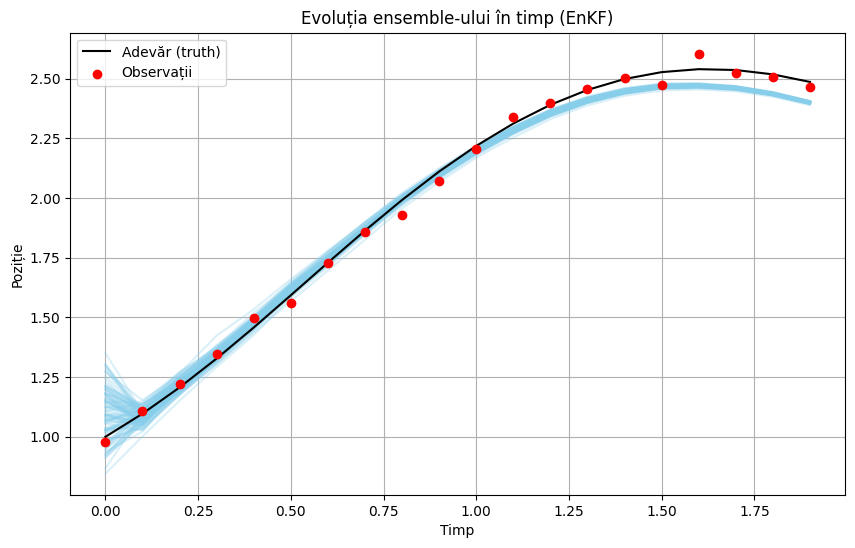

Media la pasul final: 2.3990178865179264
Deviația standard la pasul final: 0.003045397724408077


In [4]:
import numpy as np
import math 
import matplotlib.pyplot as plt

def f(x,t):
    return math.cos(t) * x + math.sin(t)


def heun_step(x, t, h):
    k1 = f(x, t)
    # k2 = f(x + h * k1, t + h)
    k2 = f(t+h, x + h * k1)
    return x + (h / 2) * (k1 + k2)

def integrate_heun(x0, t0, t_end, h):
    times = np.arange(t0, t_end + h, h)
    x = np.zeros_like(times)
    x[0] = x0
    for i in range(1, len(times)):
        x[i] = heun_step(x[i - 1], times[i - 1], h)
    return times, x

def generate_observations(x0, h, k, noise_std):
    _, truth = integrate_heun(x0, 0, h * (k-1), h)
    obs = truth + np.random.normal(0, noise_std, size=k)
    return obs, truth


def enkf(x0_mean, x0_std, obs, h, R, ensemble_size):
    k = len(obs)
    ensemble = np.random.normal(x0_mean, x0_std, size=ensemble_size)
    all_ensembles = []

    for step in range(k):
        # Model propagation
        for i in range(ensemble_size):
            ensemble[i] = heun_step(ensemble[i], step * h, h)

        all_ensembles.append(ensemble.copy())

        # Kalman update
        x_mean = np.mean(ensemble)
        P = np.var(ensemble)
        K = P / (P + R)
        obs_noise = np.random.normal(0, np.sqrt(R), size=ensemble_size)
        ensemble = ensemble + K * (obs[step] + obs_noise - ensemble)

    return np.array(all_ensembles)



# Configurare parametri
x0_true = 1.0
x0_std = 0.1
h = 0.1
k = 20
obs_noise_std = 0.03
R = obs_noise_std**2
ensemble_size = 100

# Simulări
obs, truth = generate_observations(x0_true, h, k, obs_noise_std)
all_ensembles = enkf(1.0, x0_std, obs, h, R, ensemble_size)

# Plot
plt.figure(figsize=(10, 6))
for i in range(ensemble_size):
    plt.plot(np.arange(k) * h, all_ensembles[:, i], color='skyblue', alpha=0.3)
plt.plot(np.arange(k) * h, truth, color='black', label='Adevăr (truth)')
plt.scatter(np.arange(k) * h, obs, color='red', label='Observații', zorder=10)
plt.title("Evoluția ensemble-ului în timp (EnKF)")
plt.xlabel("Timp")
plt.ylabel("Poziție")
plt.legend()
plt.grid()
plt.show()

# Medie și dev. standard la pas final
final_ensemble = all_ensembles[-1]
print("Media la pasul final:", np.mean(final_ensemble))
print("Deviația standard la pasul final:", np.std(final_ensemble))


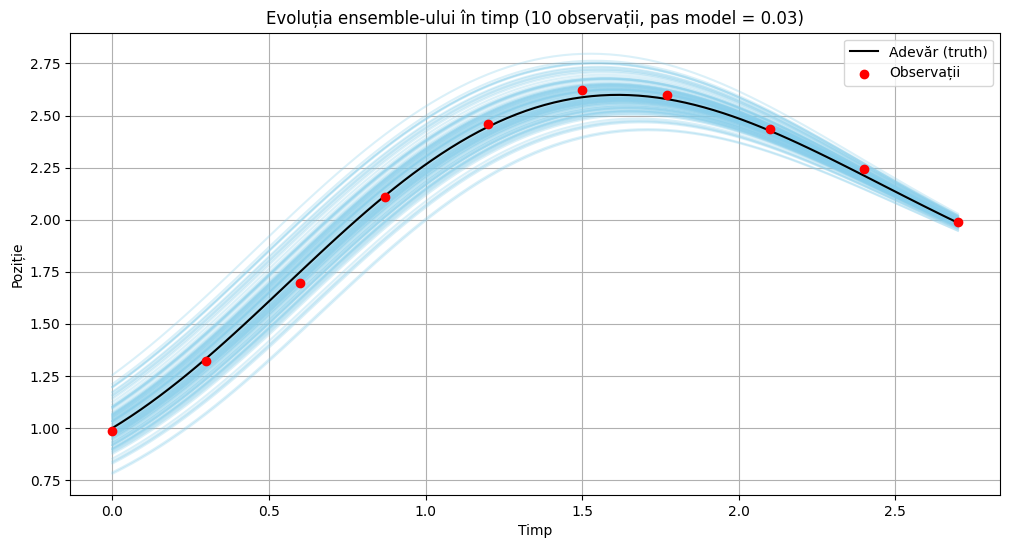

Media la pasul final: 1.9861225682453119
Deviația standard la pasul final: 0.01630599979642489


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def f(x,t):
    return math.cos(t) * x + math.sin(t)

# Pas Heun (Euler îmbunătățit)
def heun_step(x, t, h):
    k1 = f(x, t)
    k2 = f(t+h, x + h * k1)
    return x + (h / 2) * (k1 + k2)

# Integrare cu pas mic (0.03)
def integrate_heun(x0, t0, t_end, h):
    times = np.arange(t0, t_end + h, h)
    x = np.zeros_like(times)
    x[0] = x0
    for i in range(1, len(times)):
        x[i] = heun_step(x[i-1], times[i-1], h)
    return times, x

# Generare observații
def generate_observations(x0, h_obs, h_model, num_obs, noise_std):
    t_end = h_obs * (num_obs - 1)
    times_full, truth = integrate_heun(x0, 0, t_end, h_model)
    obs_indices = [int(i * h_obs / h_model) for i in range(num_obs)]
    obs_values = truth[obs_indices] + np.random.normal(0, noise_std, size=num_obs)
    obs_times = times_full[obs_indices]
    return obs_times, obs_values, truth, times_full

# EnKF cu integrare la fiecare pas mic, dar update la fiecare 0.3
def enkf_variable_update(x0_mean, x0_std, obs_times, obs_values, h_model, R, ensemble_size, t_total):
    n_steps = int(t_total / h_model) + 1
    times = np.arange(0, t_total + h_model, h_model)
    ensemble = np.random.normal(x0_mean, x0_std, size=ensemble_size)
    all_ensembles = np.zeros((n_steps, ensemble_size))
    all_ensembles[0] = ensemble

    obs_pointer = 0
    for step in range(1, n_steps):
        t = times[step-1]

        # Model propagation
        for i in range(ensemble_size):
            ensemble[i] = heun_step(ensemble[i], t, h_model)
        all_ensembles[step] = ensemble

        # Dacă e timp de observație → update EnKF
        if obs_pointer < len(obs_times) and np.isclose(times[step], obs_times[obs_pointer], atol=1e-5):
            x_mean = np.mean(ensemble)
            P = np.var(ensemble)
            K = P / (P + R)
            obs_noise = np.random.normal(0, np.sqrt(R), size=ensemble_size)
            ensemble = ensemble + K * (obs_values[obs_pointer] + obs_noise - ensemble)
            obs_pointer += 1

    return times, all_ensembles

# Setări
x0_true = 1.0
x0_std = 0.1
h_model = 0.03
h_obs = 0.3
num_obs = 10
obs_noise_std = 0.03
R = obs_noise_std ** 2
ensemble_size = 100

# Generare observații și "adevăr"
obs_times, obs_values, truth, times_full = generate_observations(x0_true, h_obs, h_model, num_obs, obs_noise_std)

# Rulare EnKF
times, all_ensembles = enkf_variable_update(1.0, x0_std, obs_times, obs_values, h_model, R, ensemble_size, t_total=obs_times[-1])

# Afișare rezultate
plt.figure(figsize=(12, 6))
for i in range(ensemble_size):
    plt.plot(times, all_ensembles[:, i], color='skyblue', alpha=0.3)
plt.plot(times_full, truth[:len(times_full)], color='black', label='Adevăr (truth)')
plt.scatter(obs_times, obs_values, color='red', label='Observații', zorder=10)
plt.title("Evoluția ensemble-ului în timp (10 observații, pas model = 0.03)")
plt.xlabel("Timp")
plt.ylabel("Poziție")
plt.legend()
plt.grid()
plt.show()

# Estimări finale
final_ensemble = all_ensembles[-1]
print("Media la pasul final:", np.mean(final_ensemble))
print("Deviația standard la pasul final:", np.std(final_ensemble))
